In [1]:
import os
import json

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

## Size of dataset

In [2]:
dataset_keys = ("train", "val", "test")
dataset_sizes = dict()
for dataset in dataset_keys:
    with open(f"data/splits/{dataset}.txt") as f:
        size = len(f.readlines())
        dataset_sizes[dataset] = size

print(f"total size: {sum(dataset_sizes.values())}")
print(dataset_sizes)

total size: 52453
{'train': 36589, 'val': 5320, 'test': 10544}


## Labels

In [3]:
labels = dict()
for fname in tqdm(list(os.listdir(os.path.join("data", "annotations")))):
    with open(os.path.join("data", "annotations", fname), "r") as fid:
        anno = json.load(fid)
        for obj in anno["objects"]:
            label = obj["label"]
            if label in labels:
                labels[label] += 1
            else:
                labels[label] = 1

100%|██████████| 41909/41909 [01:47<00:00, 389.05it/s]


In [6]:
print(f"total number of signs: {sum(labels.values())}")
print(f"number of unique labels: {len(labels)}")

total number of signs: 206386
number of unique labels: 401


### Distribution

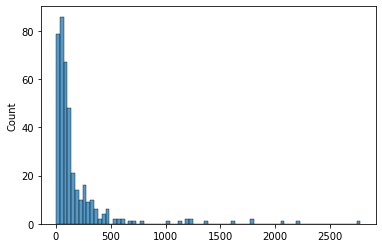

In [7]:
sorted_labels = sorted(labels.items(), key=lambda x: -x[1])
sns.histplot(x=dict(sorted_labels[1:]).values())
plt.show()

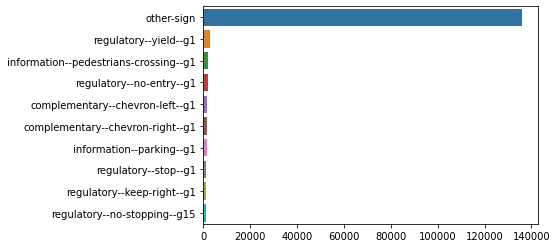

In [8]:
def make_plot(sorted_labels):
    y, x = list(zip(*sorted_labels))
    sns.barplot(x=list(x), y=list(y))
    plt.show()


make_plot(sorted_labels[:10])

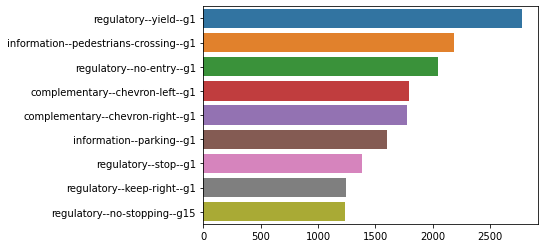

In [9]:
make_plot(sorted_labels[1:10])

how many labels occur more than 100 times

In [10]:
np.sum(np.array(list(labels.values())) > 500)

23

## Size of images

In [10]:
import torch
import cv2
import numpy as np


class MapillaryDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, dataset_key, num_images):
        """
        dataset_key (string): "train", "test" or "val"
        num_images (int): in range 1 to len(dataset)
        """
        assert dataset_key in ["train", "test", "val"]

        self.root = root
        self.transforms = transforms
        self.dataset_key = dataset_key
        self.dataset = list(sorted(os.listdir(os.path.join(root, "images", dataset_key))))[
            :num_images
        ]

    def __getitem__(self, idx):
        # load images
        image_key = self.dataset[idx]
        img_path = os.path.join(self.root, "images", self.dataset_key, image_key)

        img_bgr = cv2.imread(img_path)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)

        return img / 255

    def __len__(self):
        return len(self.dataset)

In [11]:
myDataset = MapillaryDataset(root="data", transforms=None, dataset_key="train", num_images=1000)

In [25]:
for img in myDataset:
    print(img.shape)

(3120, 4160, 3)
(2988, 3984, 3)
(2448, 3264, 3)
(1536, 2048, 3)
(3024, 4032, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2988, 3984, 3)
(2448, 3264, 3)
(3096, 4128, 3)
(2448, 3264, 3)
(3096, 4128, 3)
(2160, 3840, 3)
(3024, 4032, 3)
(3024, 4032, 3)
(2448, 3264, 3)
(2268, 4032, 3)
(2448, 3264, 3)
(3024, 4032, 3)
(3120, 4160, 3)
(1936, 2592, 3)
(2160, 3840, 3)
(1184, 1600, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2976, 3968, 3)
(3000, 4000, 3)
(1234, 1624, 3)
(2340, 4160, 3)
(3936, 5248, 3)
(3096, 4128, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(2448, 3264, 3)
(1936, 2592, 3)
(3000, 4000, 3)
(720, 1280, 3)
(3024, 4032, 3)
(1080, 1920, 3)
(768, 1280, 3)
(3000, 4000, 3)
(2448, 3264, 3)
(2160, 3920, 3)
(3456, 4608, 3)
(3120, 4160, 3)
(1080, 1920, 3)
(3120, 4160, 3)
(3024, 4032, 3)
(3024, 4032, 3)
(2448, 3264, 3)
(3000, 4000, 3)
(3096, 4128, 3)
(3072, 4096, 3)
(3000, 4000, 3)
(2160, 3840, 3)
(3024, 4032, 3)
(3456, 4608, 3)
(2448, 3264, 3)
(720, 1280, 3)
(1184, 1600, 3)
(2448, 3264, 3)
(1536, 2048, 3)
(768, 1024,

KeyboardInterrupt: 

In [18]:
myDataset[0].shape

(3120, 4160, 3)